In [1]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


import tasks.postprocessing
import tasks.constants
import tasks.graphs
import tasks.stats


tqdm.pandas()

## Load datasets

In [2]:
main_df = tasks.postprocessing.get_main_dataset()
main_df = main_df.iloc[:, [0, 1, 9, 4]]
main_df = main_df.drop_duplicates("message_id")
main_df["turns"] = "random_weighted"
main_df["prompts"] = "original"
# remove seed comments from analysis
main_df = main_df[main_df.model != hardcoded]
main_df

,conv_id,message_id,message,model,turns,prompts
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,How do you know he is not proud of his cakes? ...,hardcoded,random_weighted,original
11,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,"@SkepticalInvestor77, you're missing the point...",Mistral Nemo (abl.),random_weighted,original
22,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1583336252148959998,"@CitySlicker05, thank you for clarifying your ...",Mistral Nemo (abl.),random_weighted,original
33,3bd075d6-b91b-4f60-9138-c33feff56d2c,838628372202429525,"@SkepticalInvestor77, I understand your perspe...",Mistral Nemo (abl.),random_weighted,original
44,3bd075d6-b91b-4f60-9138-c33feff56d2c,1852804548951377081,"@GentleTherapist56, thank you for your thought...",Mistral Nemo (abl.),random_weighted,original
...,...,...,...,...,...,...
57266,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1972079638350772560,"@WanderlustNomad22, thank you for bringing up ...",Qwen 2.5,random_weighted,original
57277,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1183976761754781031,I completely agree that addressing systemic is...,Qwen 2.5,random_weighted,original
57288,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1769825593077317243,"@NatureLover88, thank you for sharing your per...",Qwen 2.5,random_weighted,original
57299,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,"@NatureLover88, I totally agree with you about...",Qwen 2.5,random_weighted,original


In [3]:
abl_df = tasks.postprocessing.get_ablation_df()
abl_df = abl_df.loc[
    :, ["conv_id", "message_id", "message", "turns", "prompts"]
]
abl_df.turns = np.where(
    abl_df.turns.apply(lambda x: str(x) == "nan"),
    "random_weighted",
    abl_df.turns,
)
abl_df.prompts = np.where(
    abl_df.prompts.apply(lambda x: str(x) == "nan"), "original", abl_df.prompts
)
abl_df["model"] = "Qwen 2.5"
abl_df

,conv_id,message_id,message,turns,prompts,model
0,e9001267-fba5-4e81-9340-10256439f896,-618891699449759534,How do you know he is not proud of his cakes? ...,random_weighted,noroles,Qwen 2.5
1,e9001267-fba5-4e81-9340-10256439f896,-300876236281035132,"@SurvivalistHunter65 Okay, first off, let’s be...",random_weighted,noroles,Qwen 2.5
2,e9001267-fba5-4e81-9340-10256439f896,-136774720061539955,NaN,random_weighted,noroles,Qwen 2.5
3,e9001267-fba5-4e81-9340-10256439f896,-170339060548748661,"@SurvivalistHunter65, @RebelliousTeen44, let's...",random_weighted,noroles,Qwen 2.5
4,e9001267-fba5-4e81-9340-10256439f896,-90638422715427188,"@RebelliousTeen44, @OptimisticNurse42 Thanks f...",random_weighted,noroles,Qwen 2.5
...,...,...,...,...,...,...
1461,86f6b244-2f63-40f1-87dc-11eb6e4e0862,1269456098477038129,NaN,random,original,Qwen 2.5
1462,86f6b244-2f63-40f1-87dc-11eb6e4e0862,2099748626367877414,@MysteriousArtist34 That's beautiful. Art and ...,random,original,Qwen 2.5
1463,86f6b244-2f63-40f1-87dc-11eb6e4e0862,1269456098477038129,NaN,random,original,Qwen 2.5
1464,86f6b244-2f63-40f1-87dc-11eb6e4e0862,-1492233235653878353,"@NatureLover88 Absolutely, I couldn't agree mo...",random,original,Qwen 2.5


Data from CeRI http://archive.regulationroom.org/

Any opinions, findings, and conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the CeRI (Cornell e-Rulemaking Initiative).

In [4]:
human_df = tasks.postprocessing.get_human_df()
human_df["model"] = "human"
human_df["turns"] = "human"
human_df["prompts"] = "human"

human_df

,conv_id,message_id,message,model,turns,prompts
0,What counts as texting,249.0,You probably ought to explicitly call out the ...,human,human,human
1,What are the risks?,250.0,I would be interested in knowing why the DOT d...,human,human,human
2,What counts as texting,251.0,I don't believe that entering a phone number o...,human,human,human
3,What are the risks?,252.0,"Personally, I don't think there should be a la...",human,human,human
4,What are the risks?,253.0,\t\t\t\t_x000D_\t\t\t\tWelcome to Regulation R...,human,human,human
...,...,...,...,...,...,...
3644,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,human,human,human
3645,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,human,human,human
3646,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,human,human,human
3647,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",human,human,human


In [5]:
df = pd.concat([main_df, abl_df, human_df], ignore_index=True)
df

,conv_id,message_id,message,model,turns,prompts
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,How do you know he is not proud of his cakes? ...,hardcoded,random_weighted,original
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,"@SkepticalInvestor77, you're missing the point...",Mistral Nemo (abl.),random_weighted,original
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1583336252148959998,"@CitySlicker05, thank you for clarifying your ...",Mistral Nemo (abl.),random_weighted,original
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,838628372202429525,"@SkepticalInvestor77, I understand your perspe...",Mistral Nemo (abl.),random_weighted,original
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,1852804548951377081,"@GentleTherapist56, thank you for your thought...",Mistral Nemo (abl.),random_weighted,original
...,...,...,...,...,...,...
8681,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,human,human,human
8682,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,human,human,human
8683,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,human,human,human
8684,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",human,human,human


In [6]:
df.message = df.message.astype(str)
df.message = np.where(df.message == "nan", "", df.message)
df

,conv_id,message_id,message,model,turns,prompts
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,How do you know he is not proud of his cakes? ...,hardcoded,random_weighted,original
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,"@SkepticalInvestor77, you're missing the point...",Mistral Nemo (abl.),random_weighted,original
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1583336252148959998,"@CitySlicker05, thank you for clarifying your ...",Mistral Nemo (abl.),random_weighted,original
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,838628372202429525,"@SkepticalInvestor77, I understand your perspe...",Mistral Nemo (abl.),random_weighted,original
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,1852804548951377081,"@GentleTherapist56, thank you for your thought...",Mistral Nemo (abl.),random_weighted,original
...,...,...,...,...,...,...
8681,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,human,human,human
8682,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,human,human,human
8683,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,human,human,human
8684,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",human,human,human


### Comment length

In [7]:
len_df = df
len_df["comment_length"] = df.message.apply(lambda x: len(x.split()))

len_df.sort_values("comment_length", ascending=False).head(10)

,conv_id,message_id,message,model,turns,prompts,comment_length
6212,What will this cost?,128.0,You mentioned that the government could subsid...,human,human,human,1629
7838,Unlawful collection practices,1205.0,I am responding to the some of the questions p...,human,human,human,1459
6897,For All Borrowers: Periodic Statements,297.0,The Periodic Statement is great and you can se...,human,human,human,1270
8555,Bicycles; Pedestrians,162.0,I&#39;m going to say something critical and un...,human,human,human,1248
6387,What will this cost?,313.0,Issue: US DOTâ€™s proposed rulemaking regardi...,human,human,human,1238
8058,Unlawful collection practices,697.0,"As an identity theft victim, I have had dozens...",human,human,human,1205
6913,"For All Borrowers: Asking For, and Getting, In...",315.0,"Moderator, why is the CFPB concerned about giv...",human,human,human,1199
7879,Questions about phones & mobile phones in debt...,1366.0,Complaints:\nâ€¢\tThe Industry is allowed to p...,human,human,human,1154
5487,peanut allergies,635.0,"As I understand it, the DOT considers peanut a...",human,human,human,1119
5962,peanut allergies,505.0,In the late 1990â€™s the U.S. Department of T...,human,human,human,1087


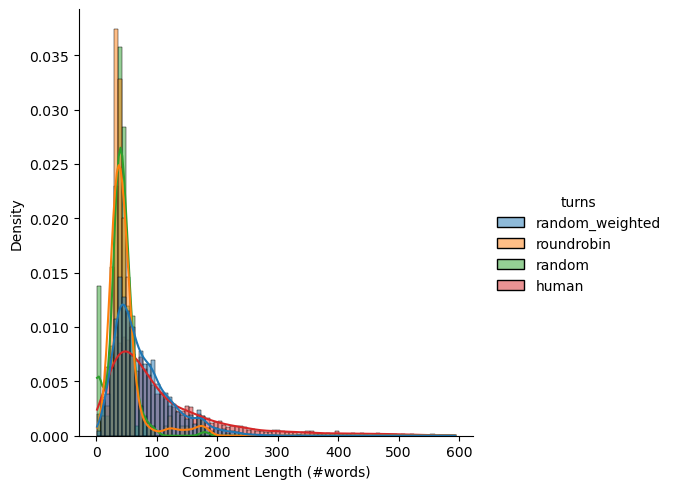

In [8]:
tasks.graphs.comment_len_plot(df, feature_col="turns")

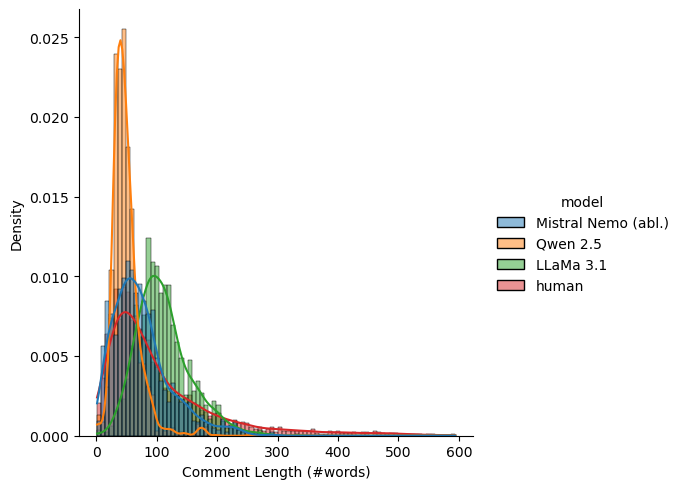

In [9]:
tasks.graphs.comment_len_plot(df[df.model != "hardcoded"], feature_col="model")

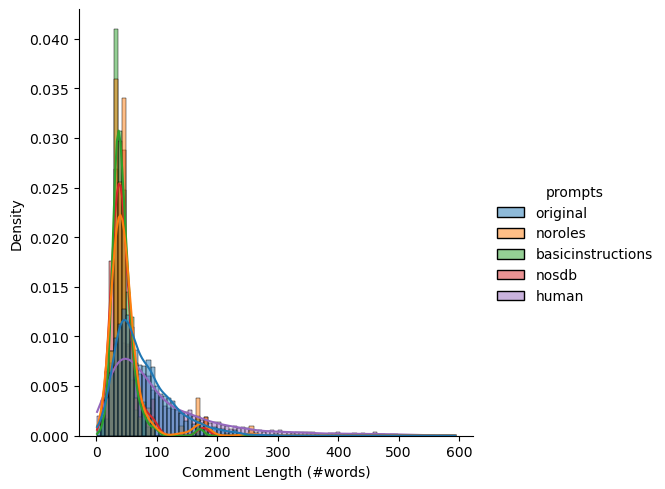

In [10]:
tasks.graphs.comment_len_plot(df, feature_col="prompts")

### Diversity

  0%|          | 0/288 [00:00<?, ?it/s]

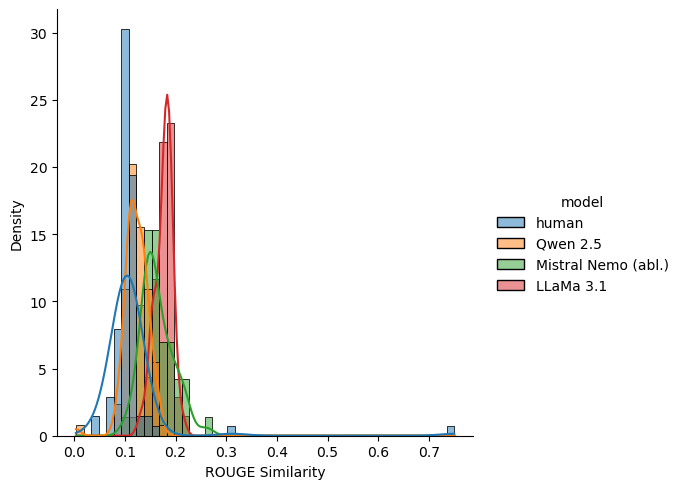

In [11]:
tasks.graphs.similarity_plot(df, feature_col="model")

In [ ]:
tasks.graphs.similarity_plot(df, feature_col="prompts")

  0%|          | 0/288 [00:00<?, ?it/s]

In [ ]:
tasks.graphs.similarity_plot(df, feature_col="turns")